<a href="https://colab.research.google.com/github/ChristineLin00/Christine/blob/master/%5BExercise%5D_%E5%88%9D%E6%8E%A2_PyTorch_%E8%88%87%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初探 PyTorch 與深度學習

請記得改變 colab 設定：`編輯` -> `筆記本設定` -> 將 `硬體加速器` 改為 `GPU`

修改成功後執行以下指令，可以看到 GPU、驅動程式（Driver）與 CUDA 等資訊

In [ ]:
!nvidia-smi

## 展示題：手寫數字辨識

MNIST 為深度學習最常用來入門的資料集，可以說是深度學習的 Hello World。這個資料集主要是由 Yann LeCun 在 1998 所蒐集的（Yann LeCun 為深度學習最重要的貢獻者，也是 Convolutional Neural Networks 的發明人），蒐集數字 0 ~ 9 的手寫數字圖片（分別對應的 label 為 `0` ~ `9`），每張圖片大小為 28 x 28。

這次練習，我們將用 PyTorch 來建構一個最簡單的 MLP，並且用 MNIST 做訓練，來預測手寫圖片為何種數字。

In [ ]:
!pip install numpy matplotlib scikit-learn torch torchvision

### Data Preprocessing

我們要準備 MNIST 的資料，準備的方式通常有兩種：
1. 自己下載 MNIST 資料到 colab 的電腦中，再做讀取
2. 直接使用 [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html) 下載 MNIST 資料，再做讀取

這次練習使用方法 2：
- 透過 `torchvision.datasets` 下載 MNIST 後，並且用 `torch.transforms.ToTensor()` 將資料轉成 [Tensor](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) 型別
- 創建 [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 的物件，這個物件負責實際的讀取資料，而且能指定 batch size 的大小（也就是一次要讀幾張圖片）

In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets

# Batch size: how many samples per batch to load.
batch_size = 16

# Convert data to torch Tensor.
transform = transforms.ToTensor()

# Download the training and testing data for MNIST.
train_data = datasets.MNIST(
    root="mnist_data",
    train=True,
    download=True,
    transform=transform,
)
test_data = datasets.MNIST(
    root="mnist_data",
    train=False,
    download=True,
    transform=transform,
)

print("Size of training set:", len(train_data))
print("Size of testing set:", len(test_data))

In [ ]:
import torch

# Create loaders for training and testing data.
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=False,
    batch_size=batch_size,
)

創建好 `DataLoader` 物件後，我們可以從中抓一把資料，一把資料的資料數量就是 batch size 的大小，每筆包含圖片與相對應的 label，圖片與 label 的型別都是 `Tensor`。由於我們在創建 training data  的 `DataLoader` 物件時有指定 `shuffle=True`，所以每次抓的資料都會不一樣。

可以看到圖片的 shape 為 `[16, 1, 28, 28]`，這種格式稱之為 `NCHW`，分別代表的意義如下：
- `N`：batch size 大小
- `C`：圖片的 channel 數量，灰階圖為 1，彩色圖通常為 3
- `H`：圖片的高度（height）
- `W`：圖片的寬度（width）


In [ ]:
# Obtain one batch of training images.
images, labels = next(iter(train_loader))

print("Images type: {}".format(type(images)))
print("Labels type: {}".format(type(labels)))
print("Images shape: {}".format(images.shape))
print("Labels shape: {}".format(labels.shape))

創建 Dataset 時指定的 [torchvision.transforms.ToTensor()](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)，除了會將圖片資料轉成 Tensor 型別之外，也會將每個像素的值從 0 到 255 normalize 到 0 跟 1，dtype 為 float

In [ ]:
print("Images data: {}".format(images[0, 0, :15, :15]))
print("Images dtype: {}".format(images.dtype))

label 的資料則會是整數，範圍從 0 到 9

In [ ]:
print("Labels data: {}".format(labels))
print("Labels dtype: {}".format(labels.dtype))

再來查看資料所在的裝置位置，一開始都會是 `cpu`

In [ ]:
print("Images device: {}".format(images.device))
print("Labels device: {}".format(labels.device))

另外，`Tensor` 型別可以與 `numpy.ndarray` 互相轉換型別。

In [ ]:
# We can also transform from Tensor to numpy.ndarray
images_np = images.numpy()
print("Type: {}, shape: {}, dtype: {}".format(type(images_np), images_np.shape, images_np.dtype))

### Data Visualization

同樣的，我們可以將從 `DataLoader` 物件拿出來的資料做視覺化。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obtain one batch of training images.
images, labels = next(iter(train_loader))
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels.
fig = plt.figure(figsize=(25, 4))
for idx in range(batch_size):
    ax = fig.add_subplot(2, int(batch_size / 2), idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    # Print out the ground truth label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Training

開始訓練之前，我們要先定義 Neural Network 的架構。[torch.nn](https://pytorch.org/docs/stable/nn.html) 包含許多深度學習的模組，例如我們這裡會用到的 `torch.nn.Flatten()`, `torch.nn.Linear`（Fully-Connected layer）、`torch.nn.Sigmoid`，透過這些模組的串連來組成我們想要的模型（下圖）。

要注意的是，由於我們等等會使用的 Cross Entropy 來當作 loss function，而 PyTorch 的 Cross Entropy 功能本身包含 Softmax，所以不會在這裡用到，而是等到訓練後的 inference 再加上去。

![](https://i.imgur.com/8n9LzOD.png)

In [ ]:
import torch.nn as nn

# Device the device by detecting the environment.
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device: {}".format(device))

# Construct the neural network.
model = nn.Sequential(
    nn.Flatten(), # (16, 1, 28, 28) -> (16, 1 * 28 * 28)
    nn.Linear(28 * 28, 512), # (16, 28 * 28) -> (16, 512)
    nn.Sigmoid(),
    nn.Linear(512, 64), # (16, 512) -> (16, 64)
    nn.Sigmoid(),
    nn.Linear(64, 10), # (16, 64) -> (16, 10)
)
# Move model target to device.
model = model.to(device)

print("Model:")
print(model)

另一種定義模型架構的方式，是去繼承 `torch.nn.Module`，`__init__()` 會先初始化好模型架構所需要的物件變數，`forward()` 則是當定義有 Tensor 輸入時，要如何對輸入做運算，並且回傳運算好的 Tensor 輸出（亦即 Feedforward）

In [ ]:
# Define the neural network class.
class MultilayerPerceptron(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Sigmoid(),
            nn.Linear(512, 64),
            nn.Sigmoid(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc_stack(x)

        return logits

# Construct the neural network.
model = MultilayerPerceptron()
# Move model from CPU to GPU.
model = model.to(device)

print(model)

這裡是用一小筆訓練資料，餵給 model 做 Feedforward 看看

要輸入給 Module 的 Tensor 必須在同個裝置上，所以這裡也有對資料呼叫 `.to()`

In [ ]:
images, _ = next(iter(train_loader))
model_out = model(images.to(device))

print("Model out shape:", model_out.shape)
print("Model out dtype:", model_out.dtype)
print("Model out device:", model_out.device)
print("Model out data:", model_out)

我們也要指定要用到的 loss function（通常會命名為 criterion）以及優化器（更新模型參數的方法，通常會命名為 optimizer），分別使用 Cross Entropy 以及 SGD

In [ ]:
# Specify loss function (Cross Entropy).
criterion = nn.CrossEntropyLoss()

# Specify optimizer (SGD w/ learning rate = 0.01).
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

接下來正式做訓練，流程基本上與課程講述的一樣

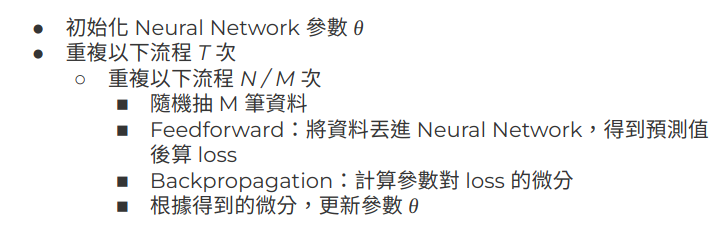

In [ ]:
# Number of epochs to train the model.
n_epochs = 30

# Turn on training mode.
model.train()

for epoch in range(n_epochs):
    # Monitor training loss.
    train_loss = 0.0

    # Train the model.
    for images, labels in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Move data to target device.
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass:
        # Compute predicted outputs by passing inputs to the model.
        model_out = model(images)
        # Calculate the loss.
        loss = criterion(model_out, labels)
        # Backward pass:
        # Compute gradient of the loss with respect to model parameters.
        loss.backward()
        # Perform a single optimization step (parameters update).
        optimizer.step()
        # Update running training loss.
        train_loss += loss.item() * images.size(0)

    # Calculate average loss over an epoch.
    train_loss = train_loss / len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {}'.format(epoch + 1, train_loss))

### Evaluation

訓練完成後，我們可以用模型來做 inference。這裡示範從 testing data 抓一把資料，餵給模型來做預測。

要注意的兩點：
1. 要將模型從 training mode 轉成 evaluation mode，因為有些深度學習的模型架構在 training mode 的行為會跟 evaluation mode 會表現不一樣
2. 由於我們定義的模型並沒有包含 Softmax，所以在 inference 的時候我們手動加上去，這樣預測的結果就會是每個 label 的機率，我們就可以將機率最大的 label 作為預測的 label。

In [ ]:
import torch.nn.functional as F

# Turn off training mode (i.e., turn on evaluation mode).
model.eval()

# Obtain one batch of testing images.
images, labels = next(iter(test_loader))

# Get sample outputs.
input_images = images.to(device)
model_out = model(input_images)
output = F.softmax(model_out, dim=1)
print("Output data: {}".format(output))
print("Output shape: {}".format(output.shape))

# Convert output probabilities to predicted class.
_, preds = torch.max(output, dim=1)
print("Prediction data: {}".format(preds))
print("Prediction shape: {}".format(preds.shape))

In [ ]:
# Plot the images in the batch, along with predicted and true labels.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size / 2), idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].numpy()), cmap="gray")

    title = "{} ({})".format(preds[idx].item(), labels[idx].item())
    color = "green" if preds[idx] == labels[idx] else "red"
    ax.set_title(title, color=color)

接下來我們可以用模型預測每筆的 testing data，將預測的 label 與真實的 label 蒐集起來，再用 scikit-learn 的 metrics 來衡量模型

In [ ]:
from sklearn.metrics import classification_report

y_pred = []
y_gt = []

for images, labels in test_loader:
    # Run inference for this batch.
    input_images = images.to(device)
    model_out = model(input_images)
    output = F.softmax(model_out, dim=1)
    _, preds = torch.max(output, dim=1)

    # Collect the predicted results for this batch.
    y_pred = y_pred + preds.tolist()
    # Collect the ground truth for this batch.
    y_gt = y_gt + labels.tolist()

print(classification_report(y_gt, y_pred))

### Model Saving & Loading

深度學習的模型訓練時間通常都很長。當我們訓練出一個還不錯的模型時，會將模型資訊儲存成檔案，這樣下次就可以直接繼續使用，不用再重新訓練一次。

PyTorch 模型相關的檔名通常以 `.pth` 或 `.pt` 結尾

例如以下程式碼會將模型參數儲存在 colab 的 `my_model.pth` 這個檔案

打開界面左邊的`檔案`查看，你可以把這個檔案下載到你的電腦

In [ ]:
torch.save(model.state_dict(), "my_model.pth")

接下來讀取模型參數檔案，並且做 inference

（可以試著把 `model.load_state_dict(torch.load("my_model.pth"))` 這行註解掉，會發現預測的結果會變很糟）

In [ ]:
# Model construction and parameters loading.
model = MultilayerPerceptron()
model.load_state_dict(torch.load("my_model.pth"))
model = model.to(device)

# Run inference.
images, labels = next(iter(test_loader))
input_images = images.to(device)
model_out = model(input_images)
output = F.softmax(model_out, dim=1)
_, preds = torch.max(output, dim=1)

print("Prediction: {}".format(preds))
print("Ground Truth: {}".format(labels))

你也可以連結你個人的 Google Drive，並將檔案儲存在之下

執行以下程式碼後，打開 [Google Drive](https://drive.google.com/drive/u/0/my-drive) 可以看到你的模型參數檔案

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/my_model.pth")

## 練習題


[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) 是另一種在深度學習更常用的 Activation Function。請將原本的模型中的 Sigmoid 改 ReLU，並且看準確率是否有上升。

In [ ]:
#@title 參考解答
# Modify the neural network class defintion as follows.
class MultilayerPerceptron(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc_stack(x)

        return logits